In [ ]:
# Aligns a score volume with an annotation volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from collections import defaultdict

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

atlasAlignOptLogs_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs_atlas')
atlasAlignParams_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams_atlas')

In [4]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [5]:
stack = 'MD589'

In [6]:
atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))

In [7]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(atlasProjected_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [8]:
def parallel_where(name, num_samples=None):
    global atlasProjected_volume, labels_sided_indices
    
    w = np.where(atlasProjected_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlasProjected_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
atlasProjected_nzs = dict(zip(available_labels_sided, atlasProjected_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 2.536448 seconds


In [ ]:
# for z in range(420,441,1):
#     print z
#     plt.figure(figsize=(10,10));
#     plt.imshow(atlasProjected_volume[..., z]);
#     plt.show();

In [9]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [ ]:
# atlas_landmark_bboxes = {}
# with open(volume_dir+'/volume_%(stack)s_annotation_withOuterContour_landmarkBboxes.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
#     for l in lines:
#         s = l.split()
#         atlas_landmark_bboxes[s[0]] = map(int, s[1:]) # xmin, xmax, ymin, ymax, zmin, zmax

In [ ]:
# Load test volume

In [10]:
params_dir = create_if_not_exists(atlasAlignParams_dir + '/' + stack)

# with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
    
# T_final = np.array(map(float, lines[1].strip().split()))

In [11]:
t = time.time()

volume2_allLabels = {}

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                      {'stack': stack, 'label': name})).astype(np.float16)
    volume2_allLabels[name] = volume2_roi
    del volume2_roi

test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape

print test_xdim, test_ydim, test_zdim

# test_xdim = volume_xmax - volume_xmin + 1
# test_ydim = volume_ymax - volume_ymin + 1
# test_zdim = volume_zmax - volume_zmin + 1

sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

838 460 454


load score volumes: 26.296769 seconds


In [12]:
########### Load Gradient ###########

dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

t1 = time.time()

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    t = time.time()
    
    dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})
    
    sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~7s

sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # 140s

load gradient RtTg: 6.971635 seconds
load gradient VLL: 8.391205 seconds
load gradient Tz: 6.739816 seconds
load gradient LC: 9.412743 seconds
load gradient 7N: 9.608276 seconds
load gradient Amb: 10.244132 seconds
load gradient 6N: 14.883078 seconds
load gradient AP: 10.920749 seconds
load gradient 5N: 28.624237 seconds
load gradient 12N: 17.833772 seconds
load gradient 7n: 13.817986 seconds
load gradient R: 16.256727 seconds
load gradient Pn: 22.359994 seconds
load gradient LRt: 14.580054 seconds
overall: 190.651153 seconds


In [13]:
def matrix_exp(w):
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    
    theta = np.sqrt(np.sum(w**2))
    
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/theta**2*np.dot(w_skew, w_skew)
    return exp_w

def matrix_exp_v(v):
    t = v[:3]
    w = v[3:]
    
    theta = np.sqrt(np.sum(w**2))
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/(theta**2)*np.dot(w_skew, w_skew)
    
    V = np.eye(3) + (1-np.cos(theta))/(theta**2)*w_skew + (theta-np.sin(theta))/(theta**3)*np.dot(w_skew, w_skew)
    
    return exp_w, np.dot(V, t)

In [14]:
def compute_score(T, name):
        
    name_unsided = labelMap_sidedToUnsided[name]
    
    pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                 c_prime=test_centroid2).astype(np.int16)
                
    xs_prime, ys_prime, zs_prime = pts_prime.T
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
    
    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    return score

In [15]:
def step(T, name, lr, verbose=False, num_samples=1000):
    '''
    T: 1x12 vector
    l: landmark class label
    '''
    
    name_unsided = labelMap_sidedToUnsided[name]
        
    pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                 c_prime=test_centroid2).astype(np.int16)
    
    xs_prime, ys_prime, zs_prime = pts_prime.T
        
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
    
    if verbose:
        print 'nz', np.count_nonzero(valid) 
        
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
        
    voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    if num_samples is not None:
        # sample some voxels # this seems to make optimization more stable than using all voxels
    
        ii = np.random.choice(range(np.count_nonzero(valid)), 
                              min(num_samples, np.count_nonzero(valid)), 
                              replace=False)
        
        dSdx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]        
        dSdy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        dSdz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        
        xss = xs_prime_valid.astype(np.float)[ii]
        yss = ys_prime_valid.astype(np.float)[ii]
        zss = zs_prime_valid.astype(np.float)[ii]
        
    else:
        # use all voxels    
        dSdx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        xss = xs_prime_valid.astype(np.float)
        yss = ys_prime_valid.astype(np.float)
        zss = zs_prime_valid.astype(np.float)

    #############################################
    
    q = np.c_[dSdx, dSdy, dSdz, -dSdy*zss + dSdz*yss, dSdx*zss - dSdz*xss, -dSdx*yss + dSdy*xss]
    
    dMdv = q.sum(axis=0)

    if verbose:
        print 'q:', q
        print 'dMdv:', dMdv
        print 'score:', score

#     lr = np.array([0, 0, 0, 0, 0, 1e-2])
    global dMdv_historical
    dMdv_historical += dMdv**2
    dMdv_adjusted = dMdv / (1e-10 + np.sqrt(dMdv_historical))
    v_opt = lr * dMdv_adjusted # no minus sign because maximizing

#     global iteration
#     lr = np.array([0, 0, 0, 0, 0, 1e-7])
#     v_opt = lr * np.exp(-iteration/1000.) * dMdv # no minus sign because maximizing
#     v_opt = lr * dMdv # no minus sign because maximizing

    if verbose:
        print 'v_opt:', v_opt

    theta = np.sqrt(np.sum(v_opt[3:]**2))
    if verbose:
        print 'theta:', theta
    assert theta < np.pi
        
    exp_w, Vt = matrix_exp_v(v_opt)
    
    if verbose:
        print 'Vt:' , Vt
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    R = Tm[:, :3]
                        
    R_new = np.dot(exp_w, R)
    t_new = np.dot(exp_w, t) + Vt
    
    if verbose:
        print '\n'

    return np.column_stack([R_new, t_new]).flatten(), score

In [ ]:
### all landmarks

In [ ]:
hessian_allLandmarks = {}

12N


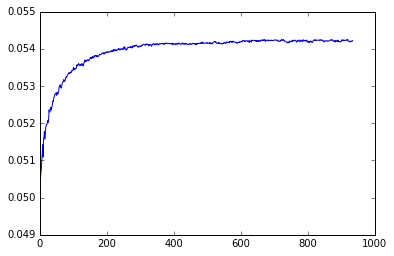

5N_L


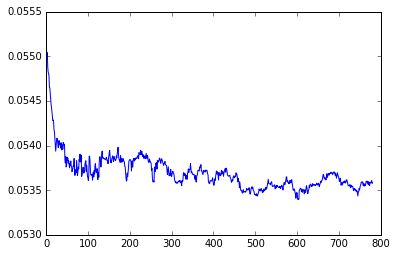

5N_R


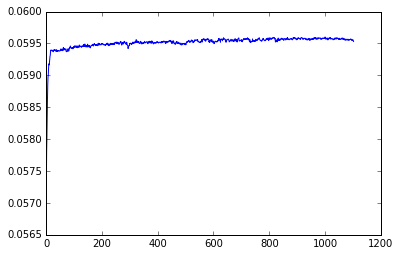

6N_L


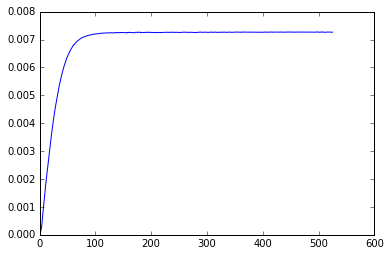

6N_R


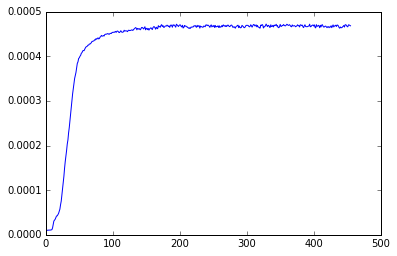

7N_L


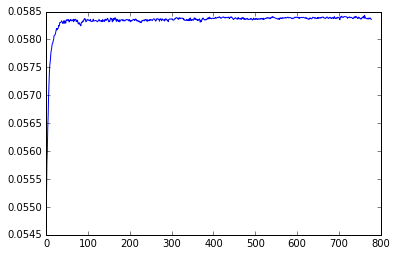

7N_R


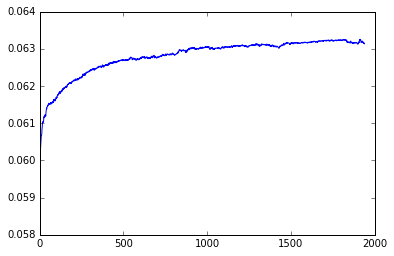

7n_L


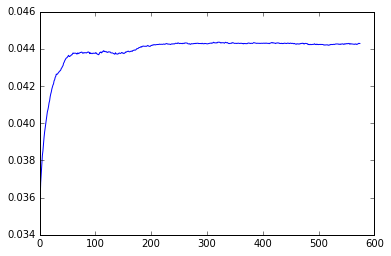

7n_R


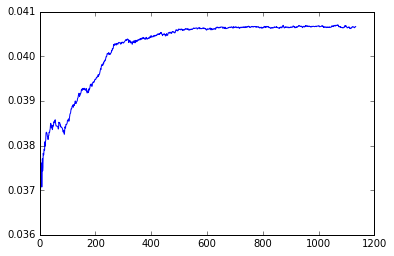

AP


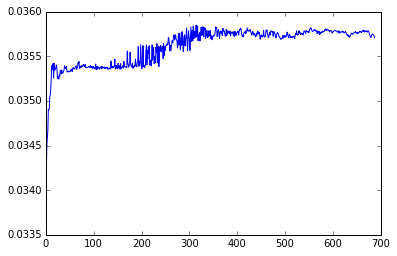

Amb_L


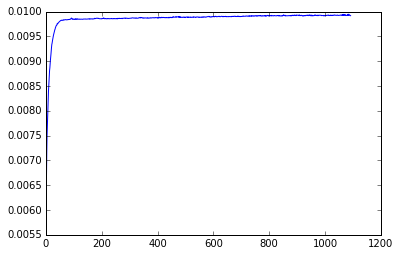

Amb_R


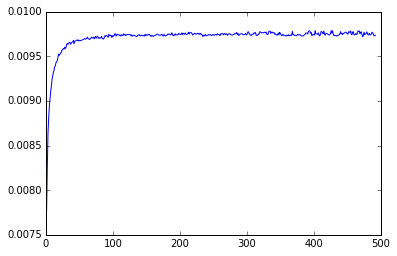

LC_L


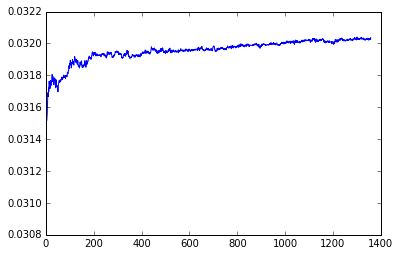

LC_R


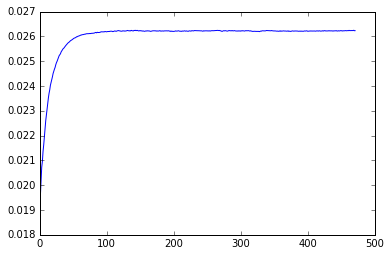

LRt_L


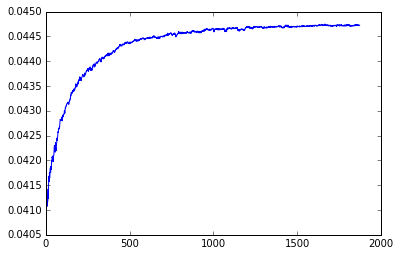

LRt_R


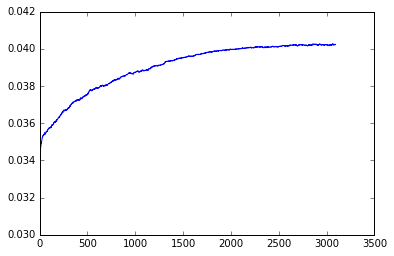

Pn_L


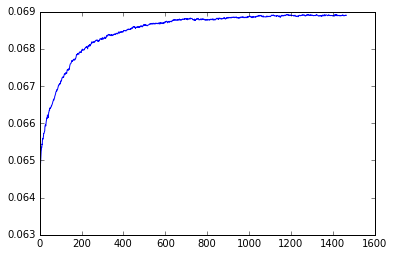

Pn_R


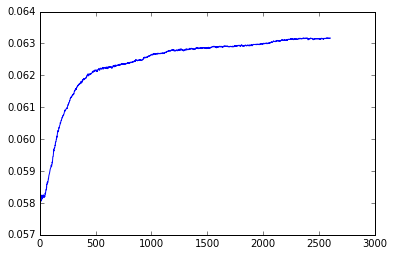

R_L


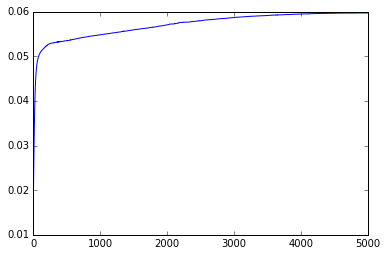

R_R


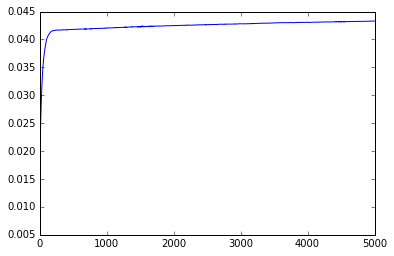

RtTg


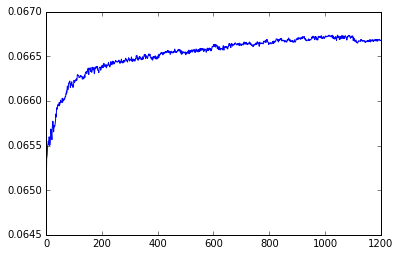

Tz_L


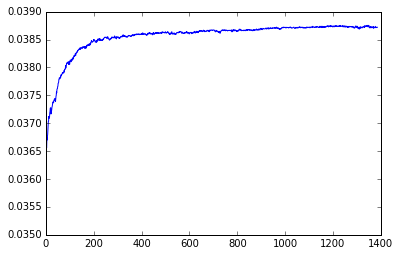

Tz_R


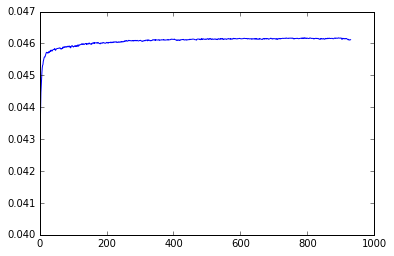

VLL_L


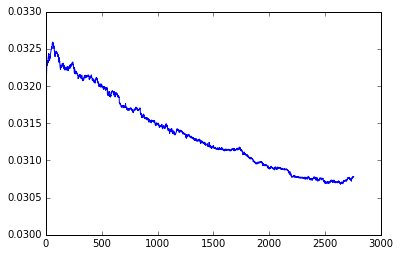

VLL_R


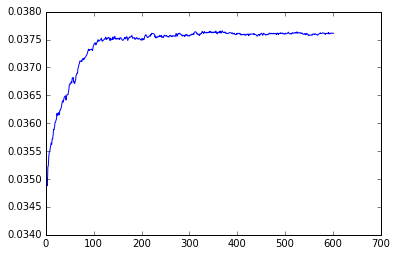

In [17]:
history_len = 200
T0 = np.array([1,0,0,0,0,1,0,0,0,0,1,0])
max_iter = 5000

for name_of_interest in available_labels_sided:
# for name_of_interest in ['6N_R']:

    if name_of_interest == 'BackG' or name_of_interest == 'outerContour':
        continue
    
    print name_of_interest
    
    # set the rotation center of both atlas and test volume to the landmark centroid after affine projection
    
    global atlasProjected_centroid, test_centroid2, atlasProjected_pts_centered
    
    atlasProjected_centroid = atlasProjected_nzs[name_of_interest].mean(axis=0)
    test_centroid2 = atlasProjected_centroid.copy()
    atlasProjected_pts_centered = {name: nzs - atlasProjected_centroid for name, nzs in atlasProjected_nzs.iteritems()}
    
    ############ gradient descent ############

    dMdv_historical = np.zeros((6,))

    score_best = 0
    scores = []
    
    T = T0.copy()

    for iteration in range(max_iter):
        
        T, s = step(T, name=name_of_interest, lr=np.array([1,1,1,1e-2,1e-2,1e-2]), verbose=False,
                    num_samples=10000)
        
#         success = False
#         c = 0
#         while not success and c < 10:
#             try:
#                 c += 1
#                 T, s = step(T, name=name_of_interest, lr=np.array([1,1,1,1e-2,1e-2,1e-2]), verbose=True,
#                             num_samples=None)
#                 success = True
#             except:
#                 pass
        
#         H = hessian(T, lambda x: score_transform(x, name_of_interest), epsilon=np.array([1e-1, 1e-1, 1e-1, 5,
#                                                                                 1e-1, 1e-1, 1e-1, 5,
#                                                                                 1e-1, 1e-1, 1e-1, 5]))
#         print H.diagonal()[[3,7,11]]
#         print H.diagonal()
#         print np.sum(H.diagonal()[[3, 7, 11]])
            
        scores.append(s)

        if iteration > 2*history_len:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-5:
                break

        if s > score_best:
            best_gradient_descent_params = T
            score_best = s
    
#     H = hessian(T, lambda x: score_transform(x, name_of_interest), epsilon=np.array([1e-1, 1e-1, 1e-1, 5,
#                                                                                 1e-1, 1e-1, 1e-1, 5,
#                                                                                 1e-1, 1e-1, 1e-1, 5]))
#     hessian_allLandmarks[name_of_interest] = H.diagonal()
#     np.save(params_dir + '/%(stack)s_%(name)s_transformUponAffineProjection_hessian.npy' % \
#             {'stack': stack, 'name': name_of_interest}, H)
    
#     with open(params_dir + '/%(stack)s_%(name)s_transformUponAffineProjection_hessian.txt' % {'stack': stack, 'name': name_of_interest}, 
#               'w') as f:
#         f.write((' '.join(['%f']*12)+'\n') % tuple(best_gradient_descent_params))
    
#     print np.sum(H.diagonal())
    
#     print score_best
#     print best_gradient_descent_params.reshape((3,4))

#     print scores[0]
#     print scores[-1]

    plt.plot(scores);
    plt.show();
    
    np.save(atlasAlignOptLogs_dir + '/%(stack)s_%(name)s_scoreEvolutions_transformUponAffineProjection.npy' % \
            {'stack':stack, 'name': name_of_interest}, scores)
    
    with open(params_dir + '/%(stack)s_%(name)s_transformUponAffineProjection.txt' % {'stack': stack, 'name': name_of_interest}, 
              'w') as f:
        f.write((' '.join(['%f']*12)+'\n') % tuple(best_gradient_descent_params))
        f.write((' '.join(['%d']*3)+'\n') % tuple(np.r_[test_xdim, test_ydim, test_zdim]))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlasProjected_centroid))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid2))